In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [7]:
# Load in stock data
ts = pd.read_csv("Data/msft-daily-closing-price.csv", 
                  parse_dates=['Date'], index_col='Date')
ts.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.534847,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.162094,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,39.572628,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,40.075405,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.254353,29645200


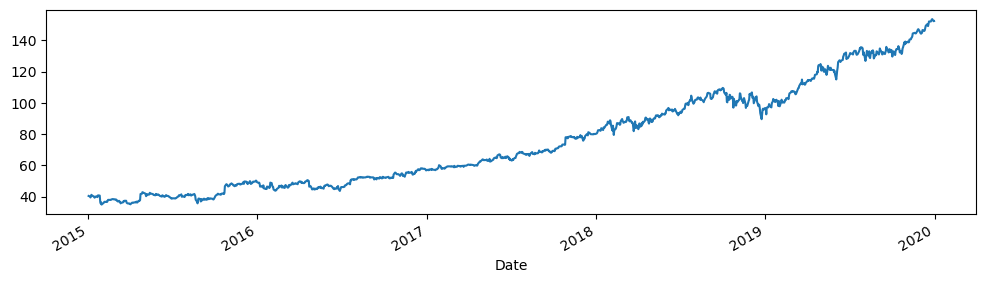

In [9]:
# Filter for 2015-2019 and only the adj close value
ts = ts.loc['2015':'2019', 'Adj Close']
ts.plot();

In [10]:
# Preview the index
ts.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)

In [11]:
# Resample for business day with 'B'
ts = ts.resample('B').asfreq()
ts

Date
2015-01-02     40.534847
2015-01-05     40.162094
2015-01-06     39.572628
2015-01-07     40.075405
2015-01-08     41.254353
                 ...    
2019-12-25           NaN
2019-12-26    153.210754
2019-12-27    153.490784
2019-12-30    152.167908
2019-12-31    152.274185
Freq: B, Name: Adj Close, Length: 1303, dtype: float64

In [12]:
# Check for nulls
ts.isna().sum()

45

In [13]:
# Inspect null values
null = ts.isna()
ts[null].head(20)

Date
2015-01-19   NaN
2015-02-16   NaN
2015-04-03   NaN
2015-05-25   NaN
2015-07-03   NaN
2015-09-07   NaN
2015-11-26   NaN
2015-12-25   NaN
2016-01-01   NaN
2016-01-18   NaN
2016-02-15   NaN
2016-03-25   NaN
2016-05-30   NaN
2016-07-04   NaN
2016-09-05   NaN
2016-11-24   NaN
2016-12-26   NaN
2017-01-02   NaN
2017-01-16   NaN
2017-02-20   NaN
Name: Adj Close, dtype: float64

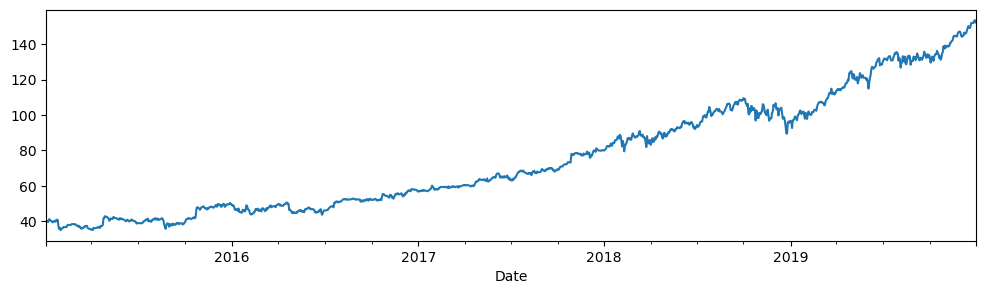

In [14]:
# Fill missing values with previous value since these are US holidays
ts = ts.fillna(method='ffill')
ts.plot();

In [15]:
# Testing the raw data for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,2.234219,8,1294,0.998909,0.05,False


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.975088,7,1294,0.0,0.05,True


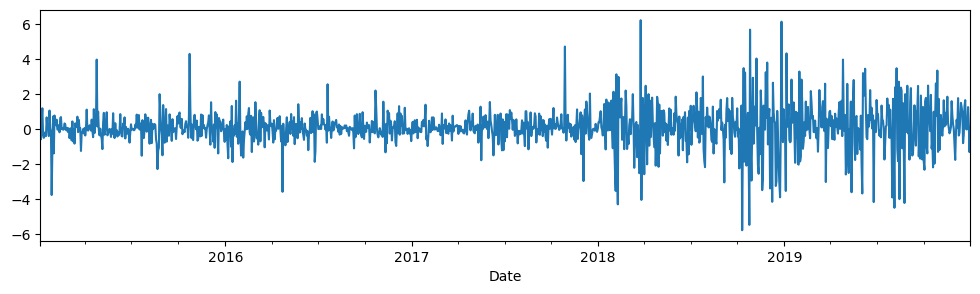

In [16]:
# Differencing the data once
ts_diff = ts.diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)

In [17]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 2


In [18]:
# Difference twice (d = 2)
ts_diff2 =ts.diff().diff().dropna()

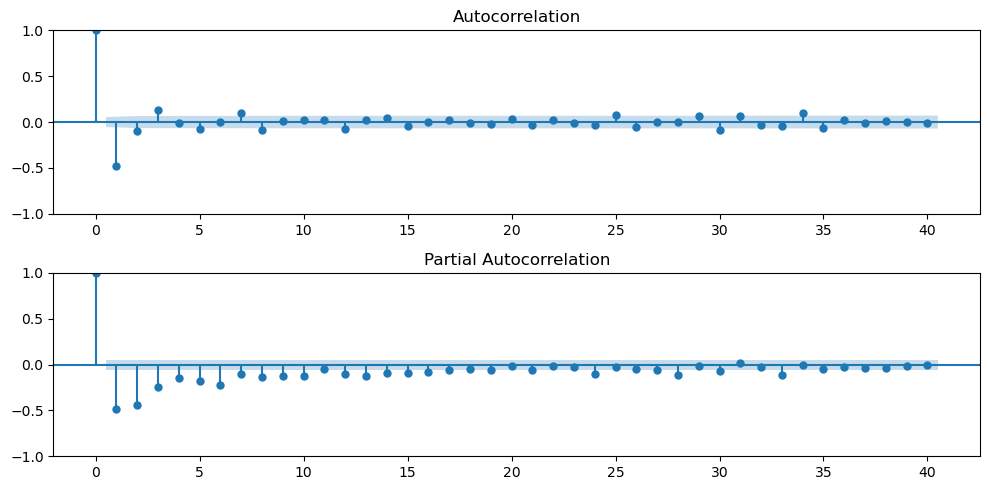

In [19]:
plot_acf_pacf(ts_diff2);

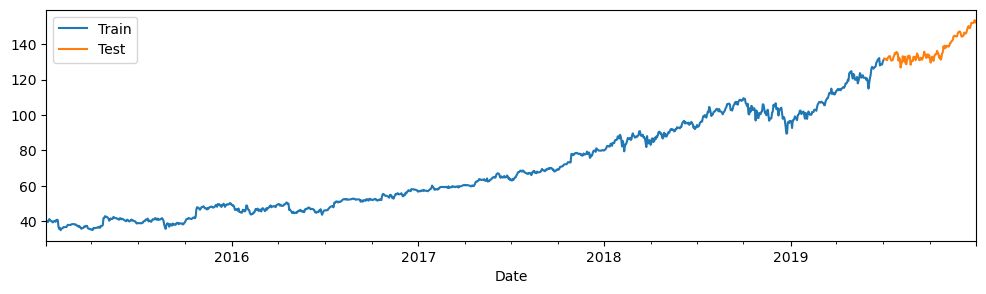

In [20]:
# Calculating number of test lags
n_test_lags = 5*26

# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [21]:
# Building the arima model 
p = 0  # AR component 

d = 2  # Number of differencing required to make stationary

q =  1 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.582
- MSE = 18.388
- RMSE = 4.288
- R^2 = 0.624
- MAPE = 2.59%


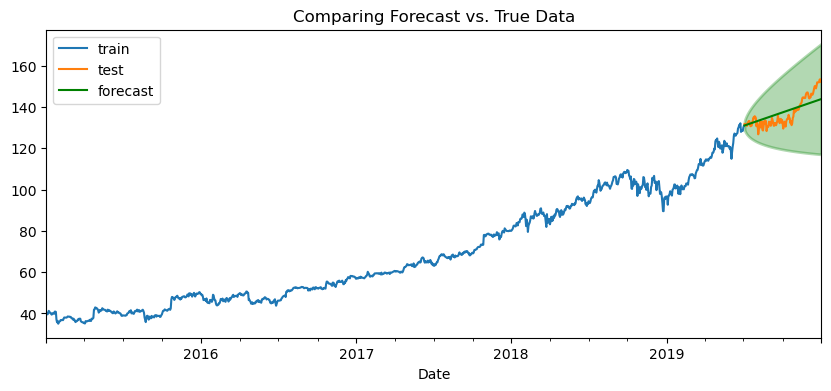

In [22]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [23]:
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1173
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1750.083
Date:                Tue, 09 Jan 2024   AIC                           3504.166
Time:                        20:25:10   BIC                           3514.298
Sample:                    01-02-2015   HQIC                          3507.987
                         - 07-02-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9983      0.004   -267.250      0.000      -1.006      -0.991
sigma2         1.1576      0.024     47.682      0.000       1.110       1.205
===================================================================================
Ljung-Box (L1) (Q):                   7.84   Jarque-Bera (JB):              1933.86
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               4.75   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

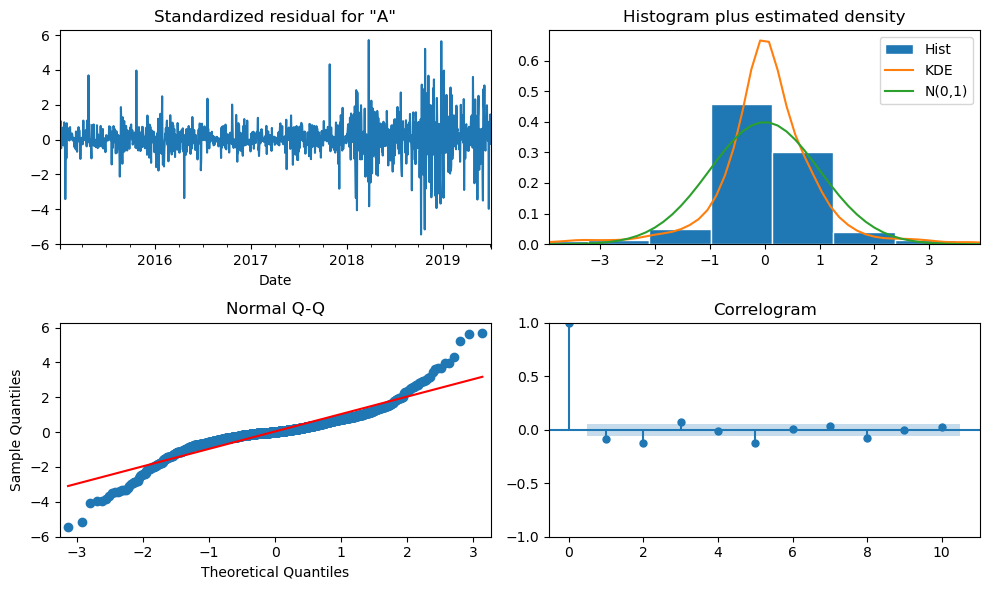

In [24]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [25]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [2]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
pdq_to_try

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3)]

In [26]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 4396.311703662399
(0, 2, 1) 3504.166347416494
(0, 2, 2) 3496.4171706437837
(0, 2, 3) 3482.6788345475666
(1, 2, 0) 4090.0964473403
(1, 2, 1) 3498.731106150687
(1, 2, 2) 3506.0915468600715
(1, 2, 3) 3482.4271106034284
(2, 2, 0) 3834.5407836007166
(2, 2, 1) 3481.142012703063
(2, 2, 2) 3480.270144187969
(2, 2, 3) 3471.1555759216026
(3, 2, 0) 3757.7619761389547
(3, 2, 1) 3479.4427428950735


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 2) 3483.9994679495817
(3, 2, 3) 3472.791392404271
Best AIC: 3471.1555759216026
Best pdq: (2, 2, 3)


In [27]:
# Build the model with the best AIC
p = 2  # AR component 

d = 2  # Number of differencing required to make stationary

q =  3 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()

In [28]:
ar_2_ma_3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1173
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -1729.578
Date:                Tue, 09 Jan 2024   AIC                           3471.156
Time:                        20:33:47   BIC                           3501.549
Sample:                    01-02-2015   HQIC                          3482.618
                         - 07-02-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5158      0.064     -8.078      0.000      -0.641      -0.391
ar.L2         -0.7524      0.058    -12.937      0.000      -0.866      -0.638
ma.L1         -0.5515      0.072     -7.645      0.000      -0.693      -0.410
ma.L2          0.1878      0.087      2.161      0.031       0.017       0.358
ma.L3         -0.6318      0.067     -9.364      0.000      -0.764      -0.500
sigma2         1.1177      0.024     47.180      0.000       1.071       1.164
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              1841.45
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               4.38   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### All the P coeffs are significant which indicates a good model

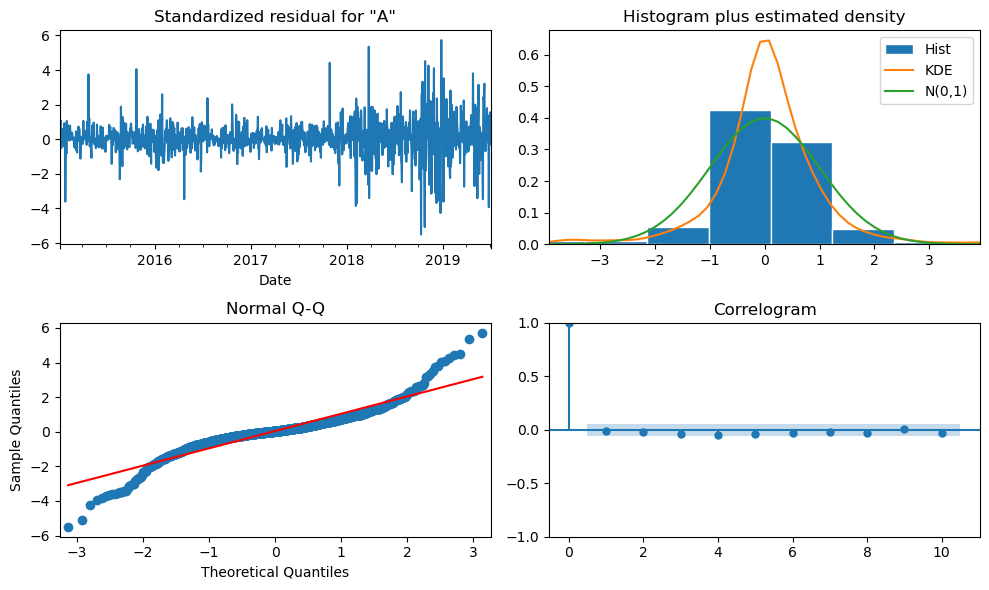

In [29]:
# Obtain diagnostic plots
fig = ar_2_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.531
- MSE = 17.446
- RMSE = 4.177
- R^2 = 0.643
- MAPE = 2.56%


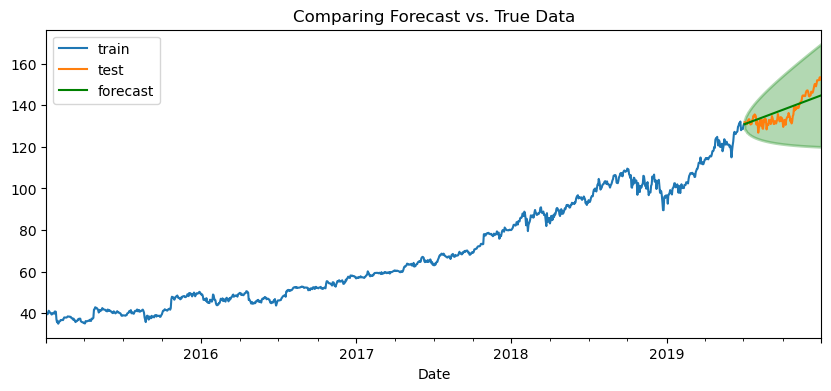

In [30]:
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])